In [91]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd

In [92]:
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



[]
Num GPUs Available:  0


In [93]:
# Configurar para usar solo la memoria necesaria
# physical_devices = tf.config.list_physical_devices('GPU')
# if physical_devices:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)
#     print('done')

In [94]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [95]:
P0_exp=df2.iloc[:, -5:]
P1_exp=df2.iloc[:, 3:9]
P2_exp=df2.iloc[:, 9:14]
P3_exp=df2.iloc[:, [15,19,20]]


P0_exp, P1_exp, P2_exp, P3_exp


(0        H7      H8      H9     H10     H11
 0    0.0921   0.092   0.093  0.0927   0.093
 1    0.0921  0.0921  0.0931  0.0932  0.0925
 2    0.0922  0.0923  0.0932  0.0932  0.0927
 3    0.0928  0.0926  0.0936  0.0937   0.093
 4    0.0933  0.0933  0.0943  0.0944  0.0938
 ..      ...     ...     ...     ...     ...
 337  1.0018  0.9769  0.9848  0.9871  0.9972
 338  1.0017    0.98  0.9857  0.9868  0.9976
 339  1.0009  0.9758  0.9833  0.9846  0.9963
 340  1.0004  0.9763  0.9843  0.9845  0.9981
 341  1.0014  0.9772  0.9853  0.9843  0.9956
 
 [342 rows x 5 columns],
 0        A1      A2      A3      A4      A5      A6
 0    0.0929  0.0971  0.0948  0.0961  0.0939  0.0934
 1    0.0925  0.0962  0.0946  0.0953  0.0935  0.0931
 2    0.0926  0.0962   0.095  0.0954  0.0936  0.0932
 3    0.0928  0.0981  0.0949  0.0956  0.0937  0.0934
 4    0.0933  0.0985  0.0953   0.096  0.0942  0.0939
 ..      ...     ...     ...     ...     ...     ...
 337  0.5954  0.6453  0.6513  0.6593  0.6599  0.6576
 338  0.5

In [96]:
P2_exp.shape

(342, 5)

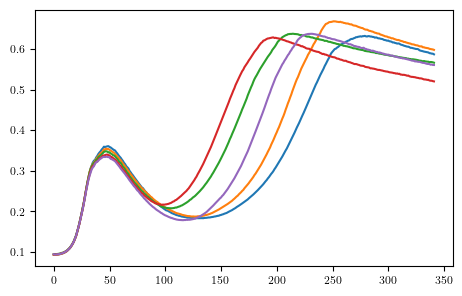

In [97]:
plt.plot(P2_exp)

In [98]:
P1_exp.shape

(342, 6)

In [99]:
c=-1
P_exp=np.hstack((P0_exp,P1_exp,P2_exp,P3_exp))
T_exp=np.array(df2['Time [s]'])

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
n=np.array([P0_exp.shape[1],P1_exp.shape[1],P2_exp.shape[1],P3_exp.shape[1],])
A=np.array([0, 1.25, 2.50, 3.75])
A=A/np.max(A)
N_exp,T_max, T_exp.shape, P_exp.shape, 342*23

(19, 231399.5, (342,), (342, 19), 7866)

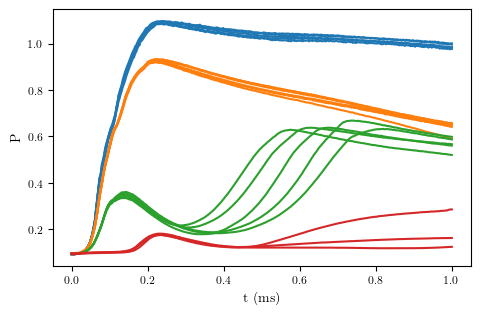

In [100]:
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)

plt.xlabel('t (ms)')
plt.ylabel('P')
plt.show()

In [101]:
N_f = 1000 # Number of residual point
N_d = 1500 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
Xa_star=[]
P0_star=np.empty((0, 1))
X_star = np.empty((0, 3))
for i in range(len(A)):
    P0=P_exp[0:1, np.sum(n[:i]):np.sum(n[:i+1])]
    P0_star=np.concatenate((P0_star,P0.T))
    T_meshgrid, P0_meshgrid, A_meshgrid = np.meshgrid(T_exp, P0, A[i])
    x=np.hstack((T_meshgrid.flatten()[:,None], P0_meshgrid.flatten()[:,None], A_meshgrid.flatten()[:,None]))
    Xa_star += [x]
    X_star=np.vstack((X_star,x))


u_star=np.hstack((P_star,X_star[:,1:2]))

In [102]:
# T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = X_star.min(0)
lb[1]=lb[1]
ub = X_star.max(0) 
ub[1]=ub[1]


# Initial Condition
xx0 = X_star[::len(T_exp)]
uu0 = P_star[::len(T_exp)]

xx1= np.hstack((np.ones(len(P0_star)).reshape([-1,1]), P0_star.reshape([-1,1]), xx0[...,2:3]))

xx01=np.vstack((xx0, xx1))
uu01=np.array([1]*N_exp+[0]*N_exp).reshape([-1,1])

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu0), replace=False)
xxd = X_star[idx]
uud = P_star[idx]

X_u_train = np.concatenate((xx0,xxd))
P_train = np.concatenate((uu0,uud))

X_f_train = lb + (ub-lb)*lhs(3, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
P_train_tf =   tf.convert_to_tensor(P_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)
xx01_tf = tf.convert_to_tensor(xx01, dtype=tf.float32)
uu01_tf = tf.convert_to_tensor(uu01, dtype=tf.float32)

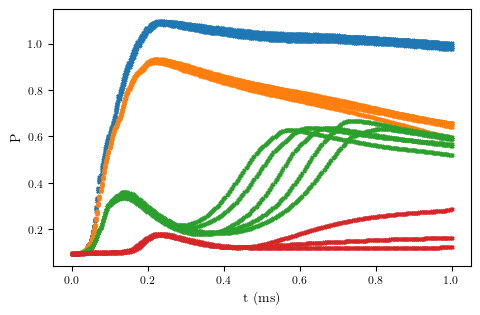

In [103]:
L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.scatter(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],P_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=5,  color=color)


plt.xlabel('t (ms)')
plt.ylabel('P')
plt.show()

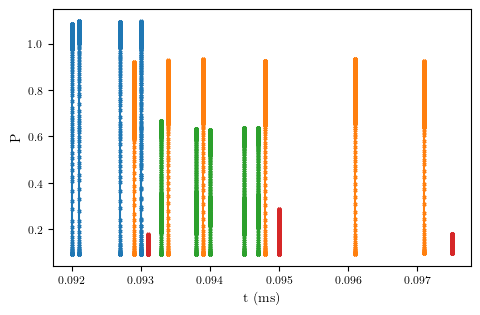

In [104]:
L_exp=len(P_exp[:,1])
for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        plt.plot(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,1],P_exp[:, (i + np.sum(n[:k]))], color=color)
        plt.scatter(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,1],P_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', color=color, s=5)

plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

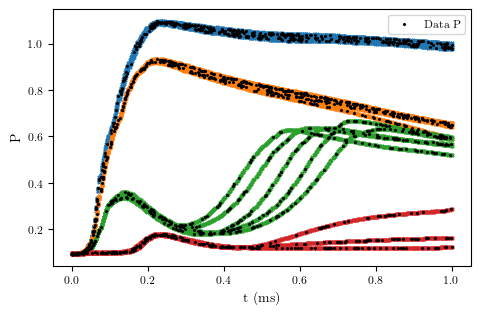

In [105]:
L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.scatter(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],P_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=5,  color=color)


plt.xlabel('t (ms)')
plt.ylabel('P')

plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')

plt.legend()

# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

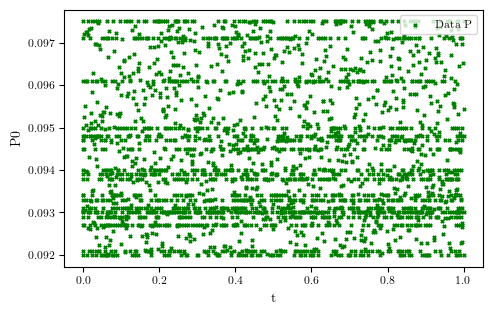

In [106]:

plt.scatter(X_f_train_tf[:,0], X_f_train_tf[:,1], s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
plt.ylabel('P0')
# plt.savefig('figures/P_phi.pdf')
plt.show()

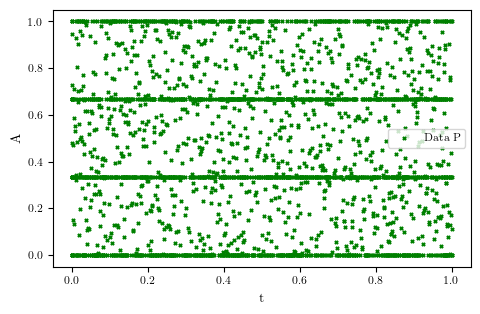

In [107]:

plt.scatter(X_f_train_tf[:,0], X_f_train_tf[:,2], s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
plt.ylabel('A')
# plt.savefig('figures/P_phi.pdf')
plt.show()

In [108]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    # A = 2.0*(X - lb)/(ub - lb) - 1.0
    A=X
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 


def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r+N_b, 2]), dtype=tf.float32)
    alpha_0 = tf.Variable(tf.reshape(tf.repeat(1000.0, N_exp*2), (N_exp*2, -1))) 
    return alpha_r, alpha_b, alpha_0


#@tf.function(jit_compile=True)
@tf.function()
def net_f(X_f, W_p, b_p, W_phi, b_phi):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([X_f])
        u=net(X_f, W_p, b_p)

        p=tf.exp(u)
       
        # m=tf.exp(lnv[0:1])
        a=X_f[...,2:3]
        t=X_f[...,0:1]
        # phi_s=tf.exp(net(tf.concat([p, s, a],1), W_a, b_a))
        
        phi=net(tf.concat([p, t, a],1), W_phi, b_phi)

        # phi=tf.exp(net(s, W_phi, b_phi))



    p_t = tape1.gradient(p, X_f)[...,0:1]

    f_p = p_t - phi*p
    
    return f_p




#@tf.function()
# @tf.function()
def train_step(W_p, b_p,  W_phi, b_phi,  X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, opt):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi, b_phi, lambda_b, lambda_r, lambda_0])
        u_nn = net(X_u_train_tf, W_p, b_p) 
        lnp=u_nn[:,0:1]
        p_nn=tf.exp(lnp)
        f_p = net_f(X_f_train_tf, W_p, b_p, W_phi, b_phi)

        u_00 = net(xx01_tf, W_p, b_p) 
        lns_0=u_00[:,1:2]
        s_00=tf.exp(lns_0)


        loss_p = tf.square(lambda_b*(p_nn - P_train_tf))
        loss_0s = tf.square(lambda_0*(s_00 - uu01_tf))
        loss_fp = tf.square(lambda_r[:,0:1]*f_p) 


        loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp)+ tf.reduce_mean(loss_fs)+ tf.reduce_mean(loss_0s)

    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))
    # grads_a = tape.gradient(loss, train_vars(W_a, b_a))

    # grads_lnv = tape.gradient(loss, lnv)
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    grads_0 = tape.gradient(loss, lambda_0)


    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))
    # opt.apply_gradients(zip(grads_a, train_vars(W_a, b_a)))

    # opt.apply_gradients(zip([grads_lnv], [lnv]))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    opt.apply_gradients(zip([-grads_0], [lambda_0]))

   
    return loss, tf.reduce_mean(tf.square((p_nn - P_train_tf))), tf.reduce_mean(tf.square(f_p)), tf.reduce_mean(tf.square(f_s))


layers = [3, 20, 20, 2]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

# layers = [3, 20, 20, 1]

# W_a = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
# b_a = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [3, 30, 30, 2]
L = len(layers)

W_phi = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

lnv = tf.Variable(tf.reshape(tf.repeat(1.0, 1), (1, -1)), dtype=tf.float32) 
lambda_r, lambda_b, lambda_0 = loss_weight(N_f, N_d)



In [109]:
# def train_dynamic_step( W_phi, b_phi,  W_a, b_a, X_f_train_tf, lambda_r, lnv, opt):
#     with tf.GradientTape(persistent=True) as tape:
#         tape.watch([W_phi, b_phi, W_a, b_a, lambda_r, lnv])

#         f_p, f_s = net_f(X_f_train_tf, W_p, b_p, W_phi, b_phi, W_a, b_a, lnv)

#         loss_fp = tf.square(lambda_r[0:1]*f_p) 
#         loss_fs = tf.square(lambda_r[1:2]*f_s) 


#         loss =  tf.reduce_mean(loss_fp)+ tf.reduce_mean(loss_fs)


#     grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))
#     grads_a = tape.gradient(loss, train_vars(W_a, b_a))

#     # grads_lnv = tape.gradient(loss, lnv)
#     grads_u = tape.gradient(loss, lambda_r)



#     opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))
#     opt.apply_gradients(zip(grads_a, train_vars(W_a, b_a)))

#     # opt.apply_gradients(zip([grads_lnv], [lnv]))
#     opt.apply_gradients(zip([-grads_u], [lambda_r]))

   
#     return loss, 0, tf.reduce_mean(tf.square(f_p)), tf.reduce_mean(tf.square(f_s))

In [110]:
lr = 5e-3




optimizer = tf.optimizers.Adam(learning_rate=lr)
optimizer2 = tf.optimizers.Adam(learning_rate=lr/5)
# optimizer3 = tf.optimizers.Adam(learning_rate=lr/100)
# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
optimizer3 = tf.optimizers.Adam(learning_rate=lr/10)

# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9, clipnorm=10.0)


start_time = time.time()
it=0
loss = []
loss_d = []
loss_fisp = []
loss_fiss = []
loss_reg=[]
# loss_fisa = []

# Make a new Function and ConcreteFunction for each optimizer.
train_step_1 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv, optimizer)
train_step_2 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, optimizer2)
train_step_3 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, optimizer3)
# train_step_3 = tf.function(train_dynamic_step).get_concrete_function(W_phi, b_phi,  W_a, b_a, X_f_train_tf, lambda_r, lnv, optimizer2)


In [123]:
Nmax=20*10**4
# Nmax=10**5



while it <= Nmax:
    # if it<5*10**4:
    loss_, loss_p, loss_fp, loss_fs = train_step_1(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)
    # elif it<10*10**4:
    #     loss_, loss_p, loss_fp, loss_fs = train_step_2(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)
    # else:
    #     loss_, loss_p, loss_fp, loss_fs = train_step_3(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)

    #     loss_, loss_p, loss_fp, loss_fs = train_step_3(W_phi, b_phi,  W_a, b_a, X_f_train_tf, lambda_r, lnv)

    loss.append(loss_)
    loss_d.append(loss_p)
    loss_fisp.append(loss_fp)
    loss_fiss.append(loss_fs)
    # loss_fisa.append(loss_fa)



    if it % 10 == 0:

        print(f"Iteration is: {it}")
        # print(f"Total loss is: {loss_}")
        print(f"Data loss is: {loss_p}")
        print(f"Physicial loss of p is: {loss_fp}")
        print(f"Physicial loss of s is: {loss_fs}")
        # if n%10000 ==0:
        #     loss_reg_=eval(W_p, b_p, W_phi_s, b_phi_s)
        #     loss_reg.append(loss_reg_)
        # print(f"Physicial loss of a is: {loss_fa}")

    it+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 182480
Data loss is: 0.000915743294171989
Physicial loss of p is: 0.0009444120223633945
Physicial loss of s is: 0.00015275341866072267
Iteration is: 182490
Data loss is: 0.0009155656443908811
Physicial loss of p is: 0.002785138785839081
Physicial loss of s is: 0.0005431467434391379
Iteration is: 182500
Data loss is: 0.0009109937236644328
Physicial loss of p is: 0.000883246015291661
Physicial loss of s is: 0.00017958387616090477
Iteration is: 182510
Data loss is: 0.0009137902525253594
Physicial loss of p is: 0.001097881468012929
Physicial loss of s is: 0.00020939709793310612
Iteration is: 182520
Data loss is: 0.0009085653000511229
Physicial loss of p is: 0.0004777714784722775
Physicial loss of s is: 0.00013727741315960884
Iteration is: 182530
Data loss is: 0.0009234385215677321
Physicial loss of p is: 0.0011600394500419497
Physicial loss of s is: 0.0001743328757584095
Iteration is: 182540
Data loss is: 0.0009095778223127127
Physicial loss of p is: 0.000572026357986033
Phys

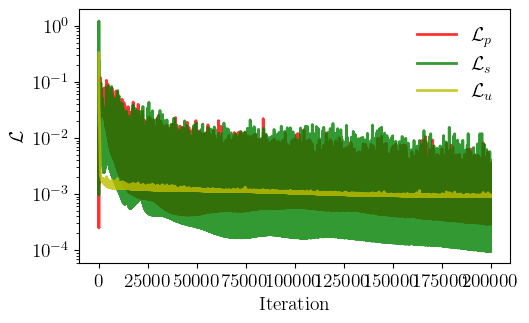

In [149]:
Nmax=len(loss)
ep = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_data_list = [loss_d[i].numpy() for i in range(0,Nmax)]

loss_phip_list = [loss_fisp[i].numpy() for i in range(0,Nmax)]
loss_phis_list = [loss_fiss[i].numpy() for i in range(0,Nmax)]



plt.semilogy(ep, np.asarray(loss_phip_list), 'r-', linewidth = 2, alpha=0.8,  label = '$\mathcal{L}_p$')    
plt.semilogy(ep, np.asarray(loss_phis_list), 'g-', linewidth = 2, alpha=0.8,  label = '$\mathcal{L}_s$')   
plt.semilogy(ep, np.asarray(loss_data_list), 'y-', linewidth = 2, alpha=0.8, label = '$\mathcal{L}_u$')  


# plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(0.77, 0.4))
plt.legend(fontsize=14, ncols=1, frameon=False)

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\mathcal{L}$', fontsize=14)    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/512_2/Loss_split.png')
plt.savefig('../Img/512_2/Loss_split.pdf')
plt.savefig('../Img/512_2/Loss_split.svg')
plt.show()

In [125]:
# lnv[0], tf.exp(lnv[0]), #lnv[1], tf.exp(lnv[1])

In [150]:
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred

## Evaluating total function
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)  
# A_star_tf = tf.convert_to_tensor(A, dtype=tf.float32)    

u_pred = predict(X_star_tf, W_p, b_p)

# ## Evaluating unknown function
lnp=u_pred[:,0:1]
lns=u_pred[:,1:2]

p=tf.exp(lnp)
s=tf.exp(lns)
a=X_star_tf[...,2:3]
# phi_s=tf.exp(net(tf.concat([p, s, a],1), W_a, b_a))
phi_t=net(tf.concat([p, s, a],1), W_phi, b_phi)
# phi = tf.exp(predict(s, W_phi, b_phi))
phi=phi_t[...,0:1]
phi_s=tf.exp(phi_t[...,1:2])

# m=tf.exp(lnv[0:1])
# l=tf.exp(lnv[1:2])


# phi_s=-np.array(p*s*m)


In [151]:
X_star_tf.shape, p.shape

(TensorShape([6498, 3]), TensorShape([6498, 1]))

In [152]:
X_star_tf[...,2:3]

<tf.Tensor: shape=(6498, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)>

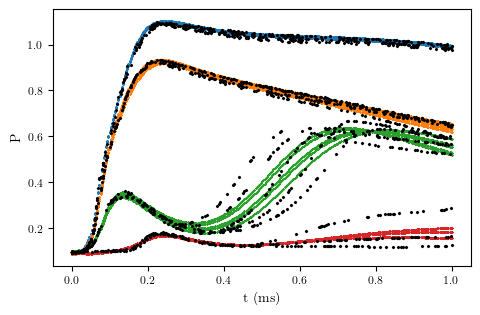

In [153]:


L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.scatter(X_star_tf[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],p[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=1,  color=color, label='Prediction P')
plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')



plt.xlabel('t (ms)')
plt.ylabel('P')


# plt.legend()

# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

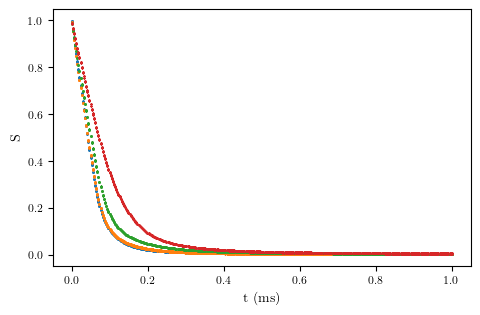

In [154]:


L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.scatter(X_star_tf[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],s[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=1,  color=color, label='Prediction P')



plt.xlabel('t (ms)')
plt.ylabel('S')
# plt.yscale('log')

# plt.legend()

# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

In [155]:


# L_exp=len(P_exp[:,1])
# colors = plt.cm.tab10.colors

# for k, j in enumerate(n):
#     # Seleccionar el color correspondiente de la paleta
#     color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
#     for i in range(j):
#         # Aquí puedes pasar el color seleccionado en cada iteración
#         # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
#         plt.scatter(X_star_tf[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,2],l[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', color=color, label='Prediction P')



# plt.xlabel('A')
# plt.ylabel('death rate')
# # plt.yscale('log')

# # plt.legend()

# # plt.ylabel('P')
# # plt.savefig('figures/P_phi.pdf')
# plt.show()

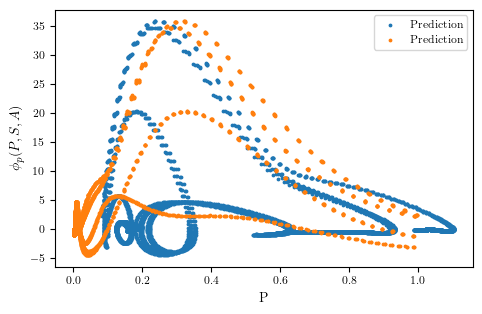

In [156]:
plt.scatter(p, phi, s=3, label='Prediction')
plt.scatter(s, phi, s=3, label='Prediction')

# plt.plot(u_pred[:,1:2], phi_pred, label='Prediction')

# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('P')
plt.ylabel('$\phi_p(P,S,A)$')
# plt.savefig('figures/phi.pdf')
plt.show()

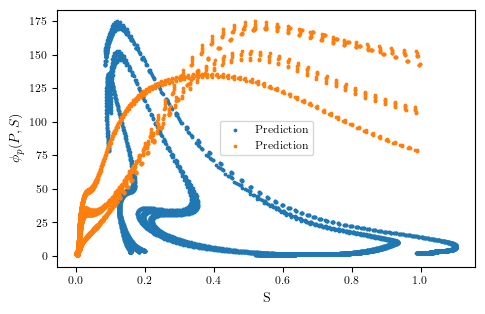

In [157]:
plt.scatter(p, phi_s, s=3, label='Prediction')

plt.scatter(s, phi_s, s=3, label='Prediction')

# plt.scatter(a, phi_s, s=3, label='Prediction')


# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('S')
plt.ylabel('$\phi_p(P,S)$')
# plt.savefig('figures/phi.pdf')
plt.show()

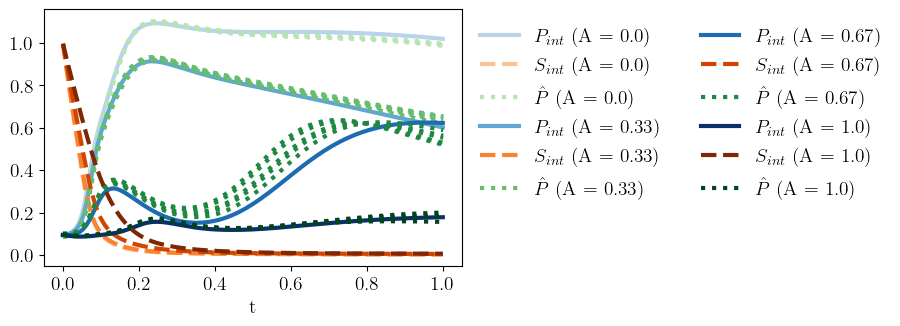

In [158]:
Nt=1000

colors_p = plt.cm.Blues(np.linspace(0.3, 1, len(A)))
colors_s = plt.cm.Oranges(np.linspace(0.3, 1, len(A)))
colors_t = plt.cm.Greens(np.linspace(0.3, 1, len(A)))


for idx, a_ in enumerate(A):

    T_int=np.zeros(Nt)
    P_int=np.zeros(Nt)
    S_int=np.zeros(Nt)


    dt=0.001

    T_int[0]=0
    P_int[0]=np.mean(P0) #Initial conditions
    # P_int[0]=np.array(p[0]) #Initial conditions

    S_int[0]=np.array(s[0]) #Initial conditions
    for i in range(1,Nt):

        PSA=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        # PHI_S=tf.exp(net(PSA, W_a, b_a))
        
        PHI_t=net(PSA, W_phi, b_phi)
        PHI=PHI_t[...,0:1]
        PHI_S=tf.exp(PHI_t[...,1:2])
        # REVISAAAAAR
        # PHI_S=tf.exp(predict(tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
        P_int[i]=P_int[i-1]+P_int[i-1]*PHI*dt
        S_int[i]=S_int[i-1]-P_int[i-1]*S_int[i-1]*PHI_S*dt
        T_int[i]=T_int[i-1]+dt


    plt.plot(T_int, P_int, linewidth=3,linestyle='-', label='$P_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_p[idx])
    plt.plot(T_int, S_int,linewidth=3, linestyle='--', label='$S_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_s[idx])

    i=0
    plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx], label='$\hat{P}$'+f' (A = {np.round(A[idx], 2)})')

    for i in range(1,n[idx]):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx])




plt.legend(fontsize=14, ncols=2, frameon=False, bbox_to_anchor=(1, 1))

plt.xlabel('t', fontsize=14)
# plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
# plt.tight_layout()
plt.savefig('../Img/512_2/Result_int.png')
plt.savefig('../Img/512_2/Result_int.pdf')
plt.savefig('../Img/512_2/Result_int.svg')
plt.show()

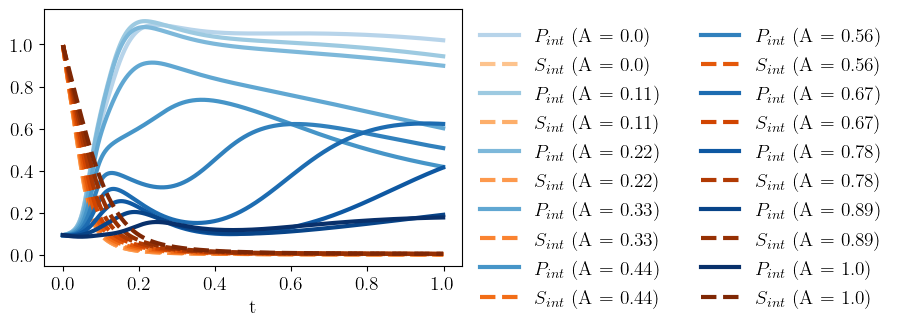

In [160]:
Nt=1000
A_int=np.linspace(0,1,10)
colors_p = plt.cm.Blues(np.linspace(0.3, 1, len(A_int)))
colors_s = plt.cm.Oranges(np.linspace(0.3, 1, len(A_int)))
for idx, a_ in enumerate(A_int):

    T_int=np.zeros(Nt)
    P_int=np.zeros(Nt)
    S_int=np.zeros(Nt)


    dt=0.001

    T_int[0]=0
    P_int[0]=np.mean(P0) #Initial conditions
    # P_int[0]=np.array(p[0]) #Initial conditions

    S_int[0]=np.array(s[0]) #Initial conditions
    for i in range(1,Nt):

        PSA=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        # PHI_S=tf.exp(net(PSA, W_a, b_a))
        
        PHI_t=net(PSA, W_phi, b_phi)
        PHI=PHI_t[...,0:1]
        PHI_S=tf.exp(PHI_t[...,1:2])
        # REVISAAAAAR
        # PHI_S=tf.exp(predict(tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
        P_int[i]=P_int[i-1]+P_int[i-1]*PHI*dt
        S_int[i]=S_int[i-1]-P_int[i-1]*S_int[i-1]*PHI_S*dt
        T_int[i]=T_int[i-1]+dt


    plt.plot(T_int, P_int, linewidth=3,linestyle='-', label='$P_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_p[idx])
    plt.plot(T_int, S_int,linewidth=3, linestyle='--', label='$S_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_s[idx])

    # i=0
    # plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx], label='$\hat{P}$'+f' (A = {np.round(A_int[idx], 2)})')

    # for i in range(1,n[idx]):
    #     # Aquí puedes pasar el color seleccionado en cada iteración
    #     # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
    #     plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx])




plt.legend(fontsize=14, ncols=2, frameon=False, bbox_to_anchor=(1, 1))

plt.xlabel('t', fontsize=14)
# plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
# plt.tight_layout()
plt.savefig('../Img/512_2/Result_int_2.png')
plt.savefig('../Img/512_2/Result_int_2.pdf')
plt.savefig('../Img/512_2/Result_int_2.svg')
plt.show()

In [136]:
hjkl

NameError: name 'hjkl' is not defined

# Symbolic Regresion

In [350]:
A_symb=np.linspace(0,1,10)
T_symb=np.linspace(0,1,200)
P0=np.mean(P_exp[::L_exp])

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [351]:
X_star_symb = np.empty((0, 3))
for i in range(len(A_symb)):
    T_meshgrid, P0_meshgrid, A_meshgrid = np.meshgrid(T_symb, P0, A_symb[i])
    x=np.hstack((T_meshgrid.flatten()[:,None], P0_meshgrid.flatten()[:,None], A_meshgrid.flatten()[:,None]))
    X_star_symb=np.vstack((X_star_symb,x))

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [352]:
X_star_symb_tf=tf.convert_to_tensor(X_star_symb, dtype=tf.float32)  
u_pred = predict(X_star_symb_tf, W_p, b_p)

# ## Evaluating unknown function
lnp=u_pred[:,0:1]
lns=u_pred[:,1:2]

p_symb=tf.exp(lnp)
s_symb=tf.exp(lns)
a_symb=X_star_symb_tf[...,2:3]
# phi_s=tf.exp(net(tf.concat([p_symb, s_symb, a_symb],1), W_a, b_a))
phi_t=net(tf.concat([p_symb, s_symb, a_symb],1), W_phi, b_phi)
phi=phi_t[...,0:1]
phi_s=tf.exp(phi_t[...,1:2])


Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

C:\Users\julia\AppData\Local\Temp\ipykernel_19240\2797789827.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición


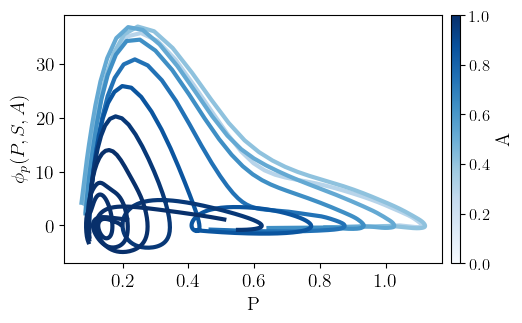

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [353]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar

# Configuración de la colormap
norm = plt.Normalize(vmin=min(A_symb), vmax=max(A_symb))  # Normaliza los valores de A_symb
cmap = cm.Blues  # Puedes cambiar "viridis" por otro mapa de colores
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necesario para asociar el colorbar

# Plot con color asociado a A_symb
for idx, a_ in enumerate(A_symb):
    c = len(T_symb) * idx
    d = len(T_symb) * (idx + 1)
    plt.plot(
        p_symb[c:d],
        phi[c:d],
        linewidth=3,
        linestyle='-',
        color=cmap(norm(a_+0.3))  # Asocia el color correspondiente a a_
    )

# Añade la colorbar
cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición
cbar.set_label('A', fontsize=14)  # Etiqueta de la colorbar
cbar.ax.tick_params(labelsize=12)

# Ejes y configuración
plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi_p(P,S,A)$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig('../Img/512_2/Phi_p_p.png')
plt.savefig('../Img/512_2/Phi_p_p.pdf')
plt.savefig('../Img/512_2/Phi_p_p.svg')
plt.show()


IndexError: index 4 is out of bounds for axis 0 with size 4

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

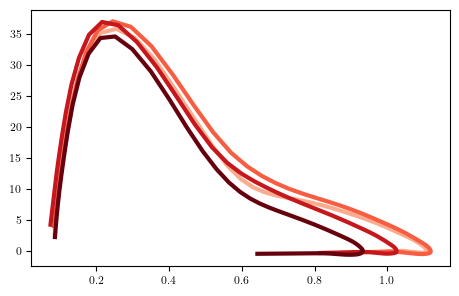

In [354]:
for idx, a_ in enumerate(A_symb):
    c=len(T_symb)*idx
    d=len(T_symb)*(idx+1)
    plt.plot( p_symb[c:d], phi[c:d], linewidth=3,linestyle='-', label='$P_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_p[idx])
    # plt.scatter( s_symb[c:d], phi[c:d], s=2, label='Prediction S')
# plt.plot( a[c:d], phi_p[c:d], label='Prediction S')


plt.legend(fontsize=14, ncols=2, frameon=False, bbox_to_anchor=(1, 1))

plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi_p(P,S,A)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
# plt.tight_layout()
# plt.savefig('../Img/512_2/Phi_p_p.png')
# plt.savefig('../Img/512_2/Phi_p_p.pdf')
# plt.savefig('../Img/512_2/Phi_p_p.svg')
plt.show()

IndexError: index 4 is out of bounds for axis 0 with size 4

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

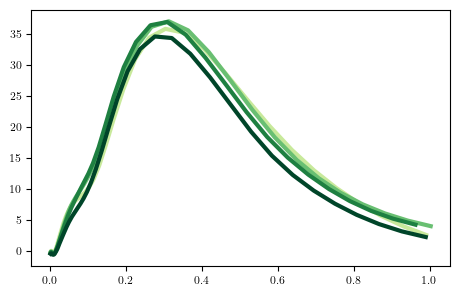

In [355]:
for idx, a_ in enumerate(A_symb):
    c=len(T_symb)*idx
    d=len(T_symb)*(idx+1)
    plt.plot( s_symb[c:d], phi[c:d], linewidth=3,linestyle='-', label='$P_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_s[idx])
    # plt.scatter( s_symb[c:d], phi[c:d], s=2, label='Prediction S')
# plt.plot( a[c:d], phi_p[c:d], label='Prediction S')


plt.legend(fontsize=14, ncols=2, frameon=False, bbox_to_anchor=(1, 1))

plt.xlabel('S', fontsize=14)
plt.ylabel('$\phi_p(P,S,A)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
# plt.tight_layout()
# plt.savefig('../Img/512_2/Phi_p_s.png')
# plt.savefig('../Img/512_2/Phi_p_s.pdf')
# plt.savefig('../Img/512_2/Phi_p_s.svg')
plt.show()

C:\Users\julia\AppData\Local\Temp\ipykernel_19240\2185518619.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición


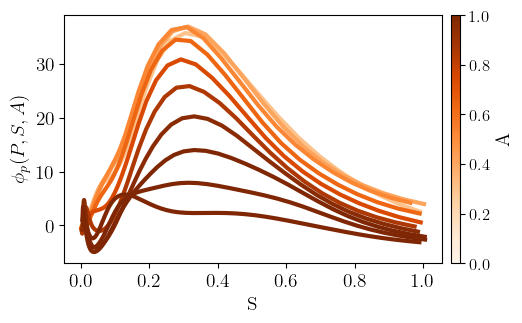

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [356]:

# Configuración de la colormap
norm = plt.Normalize(vmin=min(A_symb), vmax=max(A_symb))  # Normaliza los valores de A_symb
cmap = cm.Oranges  # Puedes cambiar "viridis" por otro mapa de colores
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necesario para asociar el colorbar

# Plot con color asociado a A_symb
for idx, a_ in enumerate(A_symb):
    c = len(T_symb) * idx
    d = len(T_symb) * (idx + 1)
    plt.plot(
        s_symb[c:d],
        phi[c:d],
        linewidth=3,
        linestyle='-',
        color=cmap(norm(a_+0.3))  # Asocia el color correspondiente a a_
    )

# Añade la colorbar
cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición
cbar.set_label('A', fontsize=14)  # Etiqueta de la colorbar
cbar.ax.tick_params(labelsize=12)

# Ejes y configuración
plt.xlabel('S', fontsize=14)
plt.ylabel('$\phi_p(P,S,A)$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig('../Img/512_2/Phi_p_s.png')
plt.savefig('../Img/512_2/Phi_p_s.pdf')
plt.savefig('../Img/512_2/Phi_p_s.svg')
plt.show()


C:\Users\julia\AppData\Local\Temp\ipykernel_19240\3905843032.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición


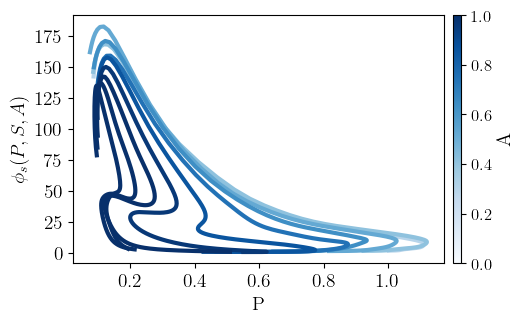

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [357]:

# Configuración de la colormap
norm = plt.Normalize(vmin=min(A_symb), vmax=max(A_symb))  # Normaliza los valores de A_symb
cmap = cm.Blues  # Puedes cambiar "viridis" por otro mapa de colores
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necesario para asociar el colorbar

# Plot con color asociado a A_symb
for idx, a_ in enumerate(A_symb):
    c = len(T_symb) * idx
    d = len(T_symb) * (idx + 1)
    plt.plot(
        p_symb[c:d],
        phi_s[c:d],
        linewidth=3,
        linestyle='-',
        color=cmap(norm(a_+0.3))  # Asocia el color correspondiente a a_
    )

# Añade la colorbar
cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición
cbar.set_label('A', fontsize=14)  # Etiqueta de la colorbar
cbar.ax.tick_params(labelsize=12)

# Ejes y configuración
plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi_s(P,S,A)$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig('../Img/512_2/Phi_s_p.png')
plt.savefig('../Img/512_2/Phi_s_p.pdf')
plt.savefig('../Img/512_2/Phi_s_p.svg')
plt.show()


C:\Users\julia\AppData\Local\Temp\ipykernel_19240\2087765801.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición


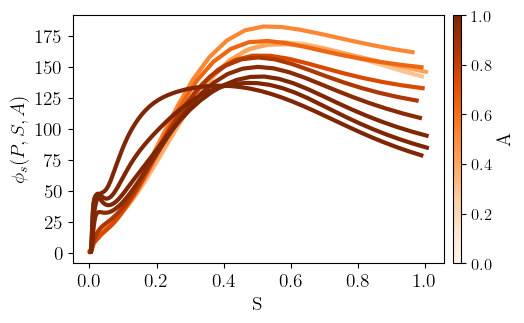

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [358]:

# Configuración de la colormap
norm = plt.Normalize(vmin=min(A_symb), vmax=max(A_symb))  # Normaliza los valores de A_symb
cmap = cm.Oranges  # Puedes cambiar "viridis" por otro mapa de colores
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necesario para asociar el colorbar

# Plot con color asociado a A_symb
for idx, a_ in enumerate(A_symb):
    c = len(T_symb) * idx
    d = len(T_symb) * (idx + 1)
    plt.plot(
        s_symb[c:d],
        phi_s[c:d],
        linewidth=3,
        linestyle='-',
        color=cmap(norm(a_+0.3))  # Asocia el color correspondiente a a_
    )

# Añade la colorbar
cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición
cbar.set_label('A', fontsize=14)  # Etiqueta de la colorbar
cbar.ax.tick_params(labelsize=12)

# Ejes y configuración
plt.xlabel('S', fontsize=14)
plt.ylabel('$\phi_s(P,S,A)$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig('../Img/512_2/Phi_s_s.png')
plt.savefig('../Img/512_2/Phi_s_s.pdf')
plt.savefig('../Img/512_2/Phi_s_s.svg')
plt.show()


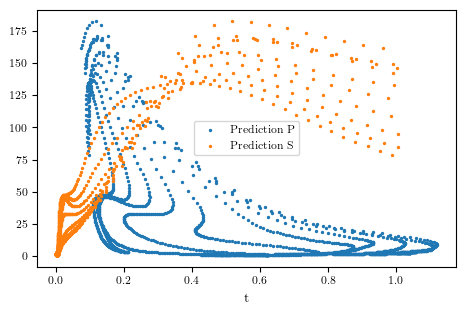

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.    , 0.0921, 0.    ], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.9970674, 0.0975   , 1.       ], dtype=float32)>)

In [170]:
c=0
d=-1
plt.scatter( p_symb[c:d], phi_s[c:d], s=2, label='Prediction P')
plt.scatter( s_symb[c:d], phi_s[c:d], s=2, label='Prediction S')
# plt.plot( a[c:d], phi_p[c:d], label='Prediction S')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()
X_star_tf[c:d][0], X_star_tf[c:d][-1]

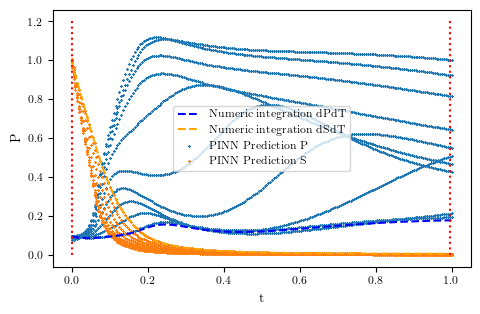

In [171]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')




plt.scatter(X_star_symb_tf[:,0], p_symb, marker='x', s=1,  label='PINN Prediction P')
plt.scatter(X_star_symb_tf[:,0], s_symb, marker='x', s=1,  label='PINN Prediction S')


plt.vlines(X_star_symb_tf[c:d][:,0][0],0,1.2, color='red', linestyle=':')
plt.vlines(X_star_symb_tf[c:d][:,0][-1],0,1.2, color='red', linestyle=':')


plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

In [291]:
# Create and train the PySR model
model_phi= PySRRegressor(
    niterations=200,
    # binary_operators=["+", "*", "inv(x, y) = x/(x + y)", "^"],
    binary_operators=["+", "*", "inv(x, y) = x/(x + y)"],

    # unary_operators=["inv(x) = 1/x"],
    # unary_operators=["exp","inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x, y: x/(x+y),},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    complexity_of_variables=1,
    complexity_of_constants=1,
    complexity_of_operators={"inv": 3},
    parsimony=0.000001,
    # select_k_features=2,
    # constraints={"^": (3, 1)},
    maxsize=30,
    progress=True  # Show progress during training
)

In [292]:
# p1s=tf.concat([p1[c:d], s[c:d]], axis=1)

min_cols_phi_p= tf.math.reduce_min(phi, axis=0)
max_cols_phi_p= tf.math.reduce_max(phi, axis=0)

phi_p_scaled = (phi-min_cols_phi_p)/(max_cols_phi_p-min_cols_phi_p)

min_cols_phi_s= tf.math.reduce_min(phi_s, axis=0)
max_cols_phi_s= tf.math.reduce_max(phi_s, axis=0)

phi_s_scaled = (phi_s-min_cols_phi_s)/(max_cols_phi_s-min_cols_phi_s)

PSA_tf=tf.concat([p_symb, s_symb, a_symb],1)
# PSA_tf=tf.concat([s_symb, a_symb],1)
PHI_SCALED_tf=tf.concat([phi_p_scaled, phi_s_scaled],1)

In [293]:
model_phi.fit(PSA_tf,PHI_SCALED_tf)
print(model_phi)


c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 5.400e+04
Head worker occupation: 25.6%
Progress: 142 / 6000 total iterations (2.367%)
Best equations for output 1
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
3           1.748e-02  5.314e+00  y₀ = 0.39739 * 0.39739
5           1.443e-02  9.605e-02  y₀ = (x₀ * x₁) + 0.16139
7           9.812e-03  1.928e-01  y₀ = 0.10511 + (3.5789 * (x₀ * x₁))
9           9.666e-03  7.461e-03  y₀ = (x₁ * ((2.0255 * x₀) * 2.0255)) + 0.10225
11          9.113e-03  2.947e-02  y₀ = ((2.0255 * x₀) * inv(x₁, x₀)) + 0.10225
13          8.097e-03  5.910e-02  y₀ = (((2.0255 + 0.6846) * x₀) * inv(x₁, x₀)) + 0.10225
17          7.194e-03  2.958e-02  y₀ = inv((x₁ + 0.015335) * inv(x₀, x₁ * (x₂ + x₁)), 0.19024)
19          6.536e-03  4.793e-02  y₀ = inv((x₁ + 0.015335) * inv(x₀, x₁ * ((x₁ * x₁) + x₂)), 0.1...
                                  9024)
21          6.219e-03  

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

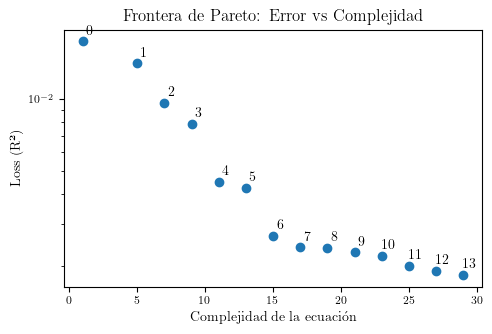

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [294]:
# Extraer las métricas de las ecuaciones
equations_df = model_phi.equations_
equations_df_p = pd.DataFrame(equations_df[0])
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df_p['complexity']
errores = equations_df_p['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.yscale('log')
plt.show()

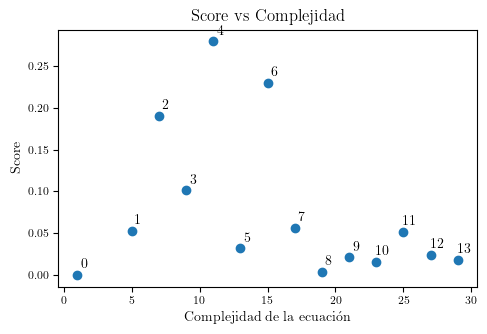

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [295]:
# Extraer complejidad y score
complejidades = equations_df_p['complexity']
scores = equations_df_p['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [296]:
equations_df_p

,complexity,loss,score,equation,sympy_format,lambda_format
0,1,0.017482,0.000000,0.15791965,0.157919650000000,PySRFunction(X=>0.157919650000000)
1,5,0.014136,0.053108,0.14435391 + (x1 * x0),x0*x1 + 0.14435391,PySRFunction(X=>x0*x1 + 0.14435391)
2,7,0.009666,0.190046,(4.1024914 * (x0 * x1)) + 0.10224795,4.1024914*x0*x1 + 0.10224795,PySRFunction(X=>4.1024914*x0*x1 + 0.10224795)
3,9,0.007896,0.101111,(7.237949 * ((x0 + -0.061178297) * x1)) + 0.09...,7.237949*x1*(x0 - 0.061178297) + 0.0906877,PySRFunction(X=>7.237949*x1*(x0 - 0.061178297)...
4,11,0.004515,0.279558,(46.252705 * (x1 * ((x0 + -0.09193437) * x1)))...,46.252705*x1*x1*(x0 - 0.09193437) + 0.12012307,PySRFunction(X=>46.252705*x1*x1*(x0 - 0.091934...
5,13,0.004237,0.031667,((0.61059815 + (35.37149 * ((-0.11144251 + x0)...,x1*(35.37149*x1*(x0 - 0.11144251) + 0.61059815...,PySRFunction(X=>x1*(35.37149*x1*(x0 - 0.111442...
6,15,0.002676,0.229766,0.11214758 + ((x1 * ((x0 + -0.07913939) * x1))...,x1*x1*(66.7689 - 67.883606*x1)*(x0 - 0.0791393...,PySRFunction(X=>x1*x1*(66.7689 - 67.883606*x1)...
7,17,0.002390,0.056540,(((x1 * (x0 + -0.085316345)) * x1) * (((x1 * -...,x1*x1*(x0 - 0.085316345)*(x1*(-66.08762)*x1 + ...,PySRFunction(X=>x1*x1*(x0 - 0.085316345)*(x1*(...
8,19,0.002374,0.003365,((((x1 * (-0.08104178 + x0)) + -0.0023673915) ...,x1*(x1*(x0 - 0.08104178) - 0.0023673915)*(x1*x...,PySRFunction(X=>x1*(x1*(x0 - 0.08104178) - 0.0...
9,21,0.002277,0.020977,(((((-0.0813347 + x0) * x1) + (-0.0025953003 *...,x1*(-66.02211*x1*x1 + 56.463634)*(x1*(x0 - 0.0...,PySRFunction(X=>x1*(-66.02211*x1*x1 + 56.46363...


Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [297]:
for i in range(len(equations_df_p)):

    print(i, sympy.simplify(model_phi.sympy([i])[0])*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p)

0 1.67684709910107
1 41.966609954834*x0*x1 + 1.10753897977238
2 172.167656426861*x0*x1 - 0.659505420321464
3 303.752182555981*x1*(x0 - 0.061178297) - 1.14464992305183
4 41.966609954834*x1**2*(46.252705*x0 - 4.25221329497085) + 0.0906527686143876
5 41.966609954834*x1*(35.37149*x1*(x0 - 0.11144251) + 0.61059815) - 0.284409119543457
6 -41.966609954834*x1**2*(x0 - 0.07913939)*(67.883606*x1 - 66.7689) - 0.244051509414292
7 41.966609954834*x1**2*(56.876205 - 66.08762*x1**2)*(x0 - 0.085316345) - 0.144851844001694
8 41.966609954834*x1*(56.465363 - 66.021736*x1**2)*(x1*(x0 - 0.08104178) - 0.0023673915) - 0.028188277455711
9 -41.966609954834*x1*(66.02211*x1**2 - 56.463634)*(x1*(x0 - 0.0813347) - 0.0025953003*x2) - 0.055356201742172
10 -41.966609954834*x1*(66.02211*x1**2 - 56.463634)*(x1*(x0 - 0.0813347) - 0.0051906006*x2) - 0.0523855532899091
11 4.45884445351353*(x1 + (x1*(x1 - 0.4998201) + 0.10624743)*(x1 + 2.6148713*x2**3 + 0.431200749553012))/((x1*(x1 - 0.4998201) + 0.10624743)*(x1 + 2.614871

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [298]:
for i in range(len(equations_df_p)):

    print(i, sympy.expand(model_phi.sympy([i])[0])*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p)

0 1.67684709910107
1 41.966609954834*x0*x1 + 1.10753897977238
2 172.167656426861*x0*x1 - 0.659505420321464
3 303.752182555981*x0*x1 - 18.583041238808*x1 - 1.14464992305183
4 1941.069230091*x0*x1**2 - 178.450976794801*x1**2 + 0.0906527686143876
5 1484.42152435131*x0*x1**2 - 165.427660571736*x1**2 + 25.6247344001932*x1 - 0.284409119543457
6 -2848.84481532963*x0*x1**3 + 2802.06438341331*x0*x1**2 + 225.455840889849*x1**3 - 221.753666044056*x1**2 - 0.244051509414292
7 -2773.47337138329*x0*x1**4 + 2386.90151094618*x0*x1**2 + 236.62261100125*x1**4 - 203.641712788905*x1**2 - 0.144851844001694
8 -2770.70844325302*x0*x1**4 + 2369.65986497911*x0*x1**2 + 224.543144102254*x1**4 + 6.55935161753544*x1**3 - 192.041453452467*x1**2 - 5.6099126222427*x1 - 0.028188277455711
9 -2770.72413876514*x0*x1**4 + 2369.5873047105*x0*x1**2 + 225.356016609221*x1**4 + 7.19086118855442*x1**3*x2 - 192.729672552437*x1**2 - 6.14979064279136*x1*x2 - 0.055356201742172
10 -2770.72413876514*x0*x1**4 + 2369.5873047105*x0*x1**2

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [299]:
for i in range(len(equations_df_p)):

    print(i, sympy.factor(model_phi.sympy([i])[0])*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p)

0 1.67684709910107
1 41.966609954834*x0*x1 + 1.10753897977238
2 172.167656426861*x0*x1 - 0.659505420321464
3 303.752182555981*x0*x1 - 18.583041238808*x1 - 1.14464992305183
4 1941.069230091*x0*x1**2 - 178.450976794801*x1**2 + 0.0906527686143876
5 1484.42152435131*x0*x1**2 - 165.427660571736*x1**2 + 25.6247344001932*x1 - 0.284409119543457
6 -2848.84481532963*x0*x1**3 + 2802.06438341332*x0*x1**2 + 225.455840889849*x1**3 - 221.753666044056*x1**2 - 0.244051509414291
7 -2773.47337138329*x0*x1**4 + 2386.90151094618*x0*x1**2 + 236.62261100125*x1**4 - 203.641712788905*x1**2 - 0.144851844001693
8 -2770.70844325302*x0*x1**4 + 2369.65986497911*x0*x1**2 + 224.543144102254*x1**4 + 6.55935161753544*x1**3 - 192.041453452467*x1**2 - 5.6099126222427*x1 - 0.028188277455711
9 -2770.72413876514*x0*x1**4 + 2369.5873047105*x0*x1**2 + 225.356016609221*x1**4 + 7.19086118855442*x1**3*x2 - 192.729672552437*x1**2 - 6.14979064279136*x1*x2 - 0.055356201742172
10 -2770.72413876514*x0*x1**4 + 2369.5873047105*x0*x1**2

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [300]:
choose_p=4
choose_p_2=8
choose_p_3=len(equations_df_p)-1


exp=model_phi.sympy([choose_p,0])[0]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
exp_2=model_phi.sympy([choose_p_2,0])[0]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
exp_3=model_phi.sympy([choose_p_3,0])[0]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [301]:
sympy.factor(exp)

1941.069230091*(1.0*x0*x1**2 - 0.09193437*x1**2 + 4.6702491188394e-5)

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [302]:
sympy.factor(exp_2)



-2770.70844325302*(1.0*x0*x1**4 - 0.855254139333749*x0*x1**2 - 0.08104178*x1**4 - 0.0023673915*x1**3 + 0.069311317803975*x1**2 + 0.00202472137979853*x1 + 1.01736714753775e-5)

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [303]:
sympy.factor(exp_3)


-0.866994253627296*(0.108398283972176*x1**3 + 0.567086576505339*x1**2*x2**4 - 0.00167290416649823*x1**2 - 0.294977171351458*x1*x2**4 - 1.0*x1 + 0.0602514913411907*x2**4 + 0.00581299007652118)/((0.191149444305627*x1 + 1.0*x2**4 + 0.096478775)*(1.0*x1**2 - 0.5201625*x1 + 0.10624743))

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [304]:
L_symb=len(T_symb)

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

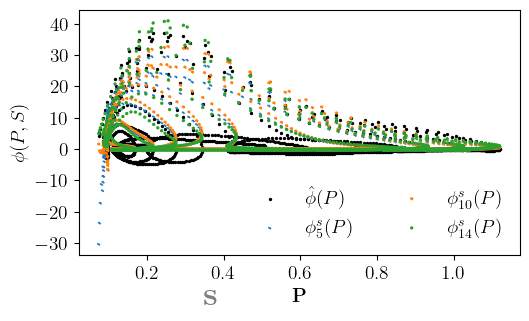

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [305]:
i=0
symb1=model_phi.predict(PSA_tf,[choose_p,0])[...,0:1]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
symb2=model_phi.predict(PSA_tf,[choose_p_2,0])[...,0:1]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
symb3=model_phi.predict(PSA_tf,[choose_p_3,0])[...,0:1]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p

# symb1=model_phi_phi.predict(s,choose,0])[...,0:1]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
# symb2=model_phi_phi.predict(s,choose_2,0])[...,0:1]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
# symb3=model_phi_phi.predict(s,choose_3,0])[...,0:1]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p


plt.scatter(p_symb, phi,linewidth= 1,s=2, color='black', label='$\hat{\phi}(P)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], phi[L_symb*i:L_symb*(i+1)],linewidth=1, color='gray', label='$\hat{\phi}(S)$')

# plt.scatter(P, phi_star, linewidth=3,linestyle='--', label='$\phi^*$')
plt.scatter(p_symb, symb1,linewidth=1, color=colors[0], s=2, linestyle=':', label='$\phi^s_5(P)$')
plt.scatter(p_symb, symb2,linewidth=1, color=colors[1],s=2, linestyle='--', label='$\phi^s_{10}(P)$')
plt.scatter(p_symb, symb3,linewidth=1, color=colors[2],s=2,linestyle='-.', label='$\phi^s_{14}(P)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], symb1,linewidth=3, color=colors[1], linestyle=':', label='$\phi^s_5(S)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], symb2,linewidth=3, color=colors[1],linestyle='--', label='$\phi^s_{10}(S)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], symb3,linewidth=3, color=colors[1],linestyle='-.', label='$\phi^s_{14}(S)$')



# plt.legend(fontsize=14, ncols=2, frameon=False,  bbox_to_anchor=(1, 1))
plt.legend(fontsize=14, ncols=2, frameon=False)


plt.xlabel(r'$\mathbf{P}$', fontsize=14, color='black')
plt.text(0.3, -0.2, r'$\mathbf{s}$', fontsize=24, color='gray', ha='center', transform=plt.gca().transAxes)


# plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P, S)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
# plt.savefig('../Img/421/Result_phi_s.png')
# plt.savefig('../Img/421/Result_phi_s.pdf')
# plt.savefig('../Img/421/Result_phi_s.svg')
plt.show()


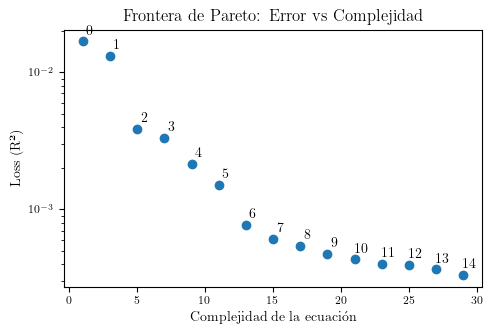

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [306]:
# Extraer las métricas de las ecuaciones
equations_df = model_phi.equations_
equations_df_p = pd.DataFrame(equations_df[1])
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df_p['complexity']
errores = equations_df_p['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.yscale('log')
plt.show()

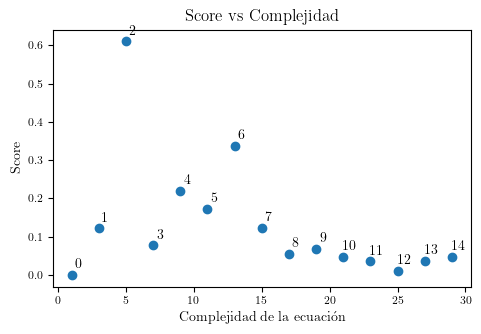

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [307]:
# Extraer complejidad y score
complejidades = equations_df_p['complexity']
scores = equations_df_p['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [308]:
equations_df_p


,complexity,loss,score,equation,sympy_format,lambda_format
0,1,0.016763,0.000000,x1,x1,PySRFunction(X=>x1)
1,3,0.013143,0.121643,x1 + 0.060167637,x1 + 0.060167637,PySRFunction(X=>x1 + 0.060167637)
2,5,0.003877,0.610433,"inv(x1, x0)",x1/(x0 + x1),PySRFunction(X=>x1/(x0 + x1))
3,7,0.003322,0.077219,"inv(x1 + 0.008456785, x0)",(x1 + 0.008456785)/(x0 + x1 + 0.008456785),PySRFunction(X=>(x1 + 0.008456785)/(x0 + x1 + ...
4,9,0.002143,0.219222,"0.81969357 * inv(x1, x0 * 0.49377868)",0.81969357*(x1/(x0*0.49377868 + x1)),PySRFunction(X=>0.81969357*(x1/(x0*0.49377868 ...
5,11,0.001519,0.172119,"inv(x1, 0.5247405 * (x0 + (x2 * x1)))",x1/(x1 + 0.5247405*(x0 + x1*x2)),PySRFunction(X=>x1/(x1 + 0.5247405*(x0 + x1*x2)))
6,13,0.000773,0.337374,"((-0.5017652 * x2) * x1) + inv(x1, x0 + -0.067...",-0.5017652*x1*x2 + x1/(x0 + x1 - 0.067821),PySRFunction(X=>-0.5017652*x1*x2 + x1/(x0 + x1...
7,15,0.000606,0.122276,"(x1 * ((-0.64153206 * x2) + x0)) + inv(x1, x0 ...",x1*(x0 - 0.64153206*x2) + x1/(x0 + x1 - 0.0649...,PySRFunction(X=>x1*(x0 - 0.64153206*x2) + x1/(...
8,17,0.000543,0.054704,"inv(x1, -0.06494252 + x0) + (((-0.5506264 * x2...",x1*(x0 - 0.5506264*x2 - 0.06494252) + x1/(x0 +...,PySRFunction(X=>x1*(x0 - 0.5506264*x2 - 0.0649...
9,19,0.000475,0.067015,"inv(x1, x0 + -0.0649976) + (x1 * ((-0.49729308...",x1*(x0 - 0.49729308*(x2*x2 + 0.34574798)) + x1...,PySRFunction(X=>x1*(x0 - 0.49729308*(x2*x2 + 0...


Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [309]:
for i in range(len(equations_df_p)):

    print(i, sympy.simplify(model_phi.sympy([0,i])[1])*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p)

0 41.966609954834*x1 - 4.95050525665283
1 41.966609954834*x1 - 2.42547350276979
2 41.966609954834*x1/(x0 + x1) - 4.95050525665283
3 41.966609954834*(x1 + 0.008456785)/(x0 + x1 + 0.008456785) - 4.95050525665283
4 34.3997603346754*x1/(0.49377868*x0 + x1) - 4.95050525665283
5 41.966609954834*x1/(0.5247405*x0 + 0.5247405*x1*x2 + x1) - 4.95050525665283
6 41.966609954834*x1*(-0.5017652*x2*(x0 + x1 - 0.067821) + 1)/(x0 + x1 - 0.067821) - 4.95050525665283
7 41.966609954834*x1*((x0 - 0.64153206*x2)*(x0 + x1 - 0.0649976) + 1)/(x0 + x1 - 0.0649976) - 4.95050525665283
8 41.966609954834*x1*(-(-x0 + 0.5506264*x2 + 0.06494252)*(x0 + x1 - 0.06494252) + 1)/(x0 + x1 - 0.06494252) - 4.95050525665283
9 41.966609954834*x1*((x0 + x1 - 0.0649976)*(x0 - 0.49729308*x2**2 - 0.171938077877978) + 1)/(x0 + x1 - 0.0649976) - 4.95050525665283
10 41.966609954834*x1*((x0 - 0.2356938*x1 - 0.4713876*x2**2)*(x0 + x1 - 0.06066773) + 1)/(x0 + x1 - 0.06066773) - 4.95050525665283
11 41.966609954834*x1*((x0 - 0.23259479*x1 - 

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [310]:
for i in range(len(equations_df_p)):

    print(i, sympy.expand(model_phi.sympy([0,i])[1])*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p)

0 41.966609954834*x1 - 4.95050525665283
1 41.966609954834*x1 - 2.42547350276979
2 41.966609954834*x1/(x0 + x1) - 4.95050525665283
3 41.966609954834*x1/(x0 + x1 + 0.008456785) - 4.95050525665283 + 0.354902597566891/(x0 + x1 + 0.008456785)
4 34.3997603346754*x1/(0.49377868*x0 + x1) - 4.95050525665283
5 41.966609954834*x1/(0.5247405*x0 + 0.5247405*x1*x2 + x1) - 4.95050525665283
6 -21.0573844373093*x1*x2 + 41.966609954834*x1/(x0 + x1 - 0.067821) - 4.95050525665283
7 41.966609954834*x0*x1 - 26.9229257355412*x1*x2 + 41.966609954834*x1/(x0 + x1 - 0.0649976) - 4.95050525665283
8 41.966609954834*x0*x1 - 23.1079233596344*x1*x2 - 2.72541740632401*x1 + 41.966609954834*x1/(x0 + x1 - 0.06494252) - 4.95050525665283
9 41.966609954834*x0*x1 - 20.8697047215981*x1*x2**2 - 7.21565825068899*x1 + 41.966609954834*x1/(x0 + x1 - 0.0649976) - 4.95050525665283
10 41.966609954834*x0*x1 - 9.89126977337265*x1**2 - 19.7825395467453*x1*x2**2 + 41.966609954834*x1/(x0 + x1 - 0.06066773) - 4.95050525665283
11 41.9666099

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [311]:
for i in range(len(equations_df_p)):

    print(i, sympy.factor(model_phi.sympy([0,i])[1])*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p)

0 41.966609954834*x1 - 4.95050525665283
1 41.966609954834*x1 - 2.42547350276979
2 41.966609954834*x1/(x0 + x1) - 4.95050525665283
3 41.966609954834*(1.0*x1 + 0.008456785)/(1.0*x0 + 1.0*x1 + 0.008456785) - 4.95050525665283
4 34.3997603346754*x1/(0.49377868*x0 + 1.0*x1) - 4.95050525665283
5 41.966609954834*x1/(0.5247405*x0 + 0.5247405*x1*x2 + 1.0*x1) - 4.95050525665283
6 -41.966609954834*x1*(0.5017652*x0*x2 + 0.5017652*x1*x2 - 0.0340302176292*x2 - 1.0)/(1.0*x0 + 1.0*x1 - 0.067821) - 4.95050525665283
7 41.966609954834*x1*(1.0*x0**2 + 1.0*x0*x1 - 0.64153206*x0*x2 - 0.0649976*x0 - 0.64153206*x1*x2 + 0.041698044223056*x2 + 1.0)/(1.0*x0 + 1.0*x1 - 0.0649976) - 4.95050525665283
8 42.1436054292525*x1*(0.995800181958431*x0**2 + 0.995800181958431*x0*x1 - 0.548313869311116*x0*x2 - 0.129339546465678*x0 - 0.548313869311116*x1*x2 - 0.064669773232839*x1 + 0.0356088844240145*x2 + 1.0)/(1.0*x0 + 1.0*x1 - 0.06494252) - 4.95050525665283
9 42.435610423549*x1*(0.988947950458733*x0**2 + 0.988947950458733*x0*

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [319]:
choose_s=2
choose_s_2=4
choose_s_3=len(equations_df_p)-1

exp=model_phi.sympy([0,choose_s])[1]*(max_cols_phi_s-min_cols_phi_s)+min_cols_phi_s
exp_2=model_phi.sympy([0,choose_s_2])[1]*(max_cols_phi_s-min_cols_phi_s)+min_cols_phi_s
exp_3=model_phi.sympy([0,choose_s_3])[1]*(max_cols_phi_s-min_cols_phi_s)+min_cols_phi_s

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [320]:
sympy.factor(exp)


182.459140300751*(0.00500108781112631*x0 + 1.0*x1)/(x0 + x1)

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [321]:
sympy.factor(exp_2)


149.725112660711*(0.00300931597230688*x0 + 1.0*x1)/(0.49377868*x0 + 1.0*x1)

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [322]:
sympy.factor(exp_3)


363.093292236328*(0.5*x0**3*x1 - 0.116297395*x0**2*x1**3 + 1.0*x0**2*x1**2 - 0.23259479*x0**2*x1*x2**2 - 0.23259479*x0**2*x1*x2 - 0.0315172225*x0**2*x1 + 0.00251311220035635*x0**2 - 0.23259479*x0*x1**4 + 0.507330741748771*x0*x1**3 - 0.46518958*x0*x1**2*x2**2 - 0.23259479*x0*x1**2*x2 - 0.0315172225*x0*x1**2 + 0.0146614834975415*x0*x1*x2**2 + 0.0146614834975415*x0*x1*x2 + 0.505026224400713*x0*x1 - 0.000158412632772191*x0 - 0.116297395*x1**5 + 0.00733074174877077*x1**4 - 0.23259479*x1**3*x2**2 + 0.0146614834975415*x1**2*x2**2 + 0.502513112200356*x1**2 - 0.000158412632772191*x1)/((x0 + x1)*(1.0*x0 + 1.0*x1 - 0.063034445))

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

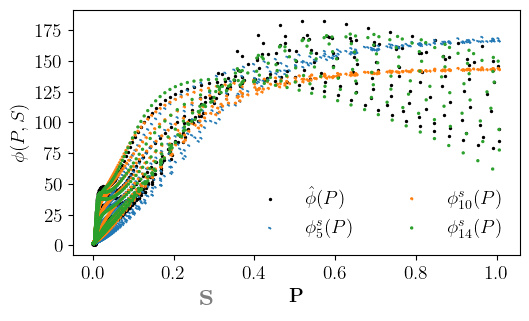

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [316]:
i=0
symb1=model_phi.predict(PSA_tf,[0,choose_s])[...,1:2]*(max_cols_phi_s-min_cols_phi_s)+min_cols_phi_s
symb2=model_phi.predict(PSA_tf,[0,choose_s_2])[...,1:2]*(max_cols_phi_s-min_cols_phi_s)+min_cols_phi_s
symb3=model_phi.predict(PSA_tf,[0,choose_s_3])[...,1:2]*(max_cols_phi_s-min_cols_phi_s)+min_cols_phi_s

# symb1=model_phi_phi.predict(s,choose,0])[...,1:2]*(max_cols_phi_s-min_cols_phi_s)+min_cols_phi_s
# symb2=model_phi_phi.predict(s,choose_2,0])[...,1:2]*(max_cols_phi_s-min_cols_phi_s)+min_cols_phi_s
# symb3=model_phi_phi.predict(s,choose_3,0])[...,1:2]*(max_cols_phi_s-min_cols_phi_s)+min_cols_phi_s


plt.scatter(s_symb, phi_s,linewidth= 1, color='black', s=2, label='$\hat{\phi}(P)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], phi[L_symb*i:L_symb*(i+1)],linewidth=1, color='gray', label='$\hat{\phi}(S)$')

# plt.scatter(P, phi_star, linewidth=3,linestyle='--', label='$\phi^*$')
plt.scatter(s_symb, symb1,linewidth=1, color=colors[0], s=2,linestyle=':', label='$\phi^s_5(P)$')
plt.scatter(s_symb, symb2,linewidth=1, color=colors[1],s=2, linestyle='--', label='$\phi^s_{10}(P)$')
plt.scatter(s_symb, symb3,linewidth=1, color=colors[2],s=2,linestyle='-.', label='$\phi^s_{14}(P)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], symb1,linewidth=3, color=colors[1], linestyle=':', label='$\phi^s_5(S)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], symb2,linewidth=3, color=colors[1],linestyle='--', label='$\phi^s_{10}(S)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], symb3,linewidth=3, color=colors[1],linestyle='-.', label='$\phi^s_{14}(S)$')



# plt.legend(fontsize=14, ncols=2, frameon=False,  bbox_to_anchor=(1, 1))
plt.legend(fontsize=14, ncols=2, frameon=False)


plt.xlabel(r'$\mathbf{P}$', fontsize=14, color='black')
plt.text(0.3, -0.2, r'$\mathbf{s}$', fontsize=24, color='gray', ha='center', transform=plt.gca().transAxes)


# plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P, S)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
# plt.savefig('../Img/421/Result_phi_s.png')
# plt.savefig('../Img/421/Result_phi_s.pdf')

# plt.savefig('../Img/421/Result_phi_s.svg')
plt.show()


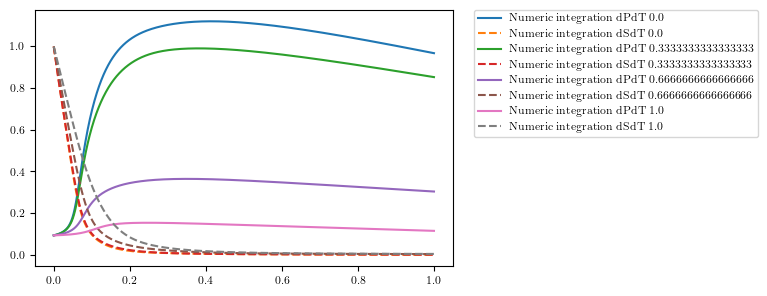

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [318]:
Nt=1000

# A_int=np.array([0,0.75, 1.25,2, 2.5,3,3.75])


for a_ in A:

    T_symb=np.zeros(Nt)
    P_symb=np.zeros(Nt)
    S_symb=np.zeros(Nt)


    dt=0.001

    T_symb[0]=0
    P_symb[0]=np.mean(P0) #Initial conditions
    # P_symb[0]=np.array(p[0]) #Initial conditions

    S_symb[0]=np.array(s[0]) #Initial conditions
    for i in range(1,Nt):

        PSA=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        # PSA=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        # PHI_S=tf.exp(net(PSA, W_a, b_a))
        
        PHI_S=tf.exp(net(PSA, W_phi, b_phi)[...,1:2])
        PHI=model_phi.predict(PSA,[choose_p_3,0])[...,0:1]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
        # REVISAAAAAR
        # PHI_S=tf.exp(predict(tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
        P_symb[i]=P_symb[i-1]+P_symb[i-1]*PHI*dt
        S_symb[i]=S_symb[i-1]-S_symb[i-1]*P_symb[i-1]*PHI_S*dt
        T_symb[i]=T_symb[i-1]+dt


    plt.plot(T_symb, P_symb,  linestyle='-', label=f'Numeric integration dPdT {a_}')
    plt.plot(T_symb, S_symb,  linestyle='--', label=f'Numeric integration dSdT {a_}')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

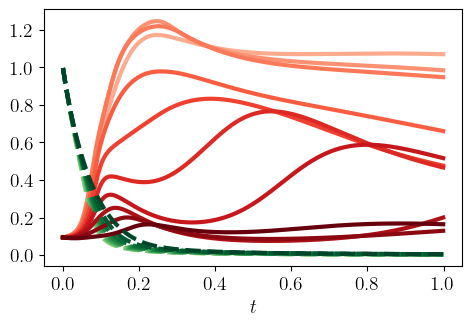

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [331]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

Nt = 1000

A_symb = np.linspace(0, 1, 10)
colors_p = plt.cm.Reds(np.linspace(0.3, 1, len(A_symb)))
colors_s = plt.cm.YlGn(np.linspace(0.3, 1, len(A_symb)))

for idx, a_ in enumerate(A_symb):
    T_symb = np.zeros(Nt)
    P_symb = np.zeros(Nt)
    S_symb = np.zeros(Nt)

    dt = 0.001

    T_symb[0] = 0
    P_symb[0] = np.mean(P0)  # Initial conditions
    S_symb[0] = np.array(s[0])  # Initial conditions

    for i in range(1, Nt):
        PSA = tf.concat([
            tf.convert_to_tensor(P_symb[i - 1].reshape([-1, 1]), dtype=tf.float32),
            tf.convert_to_tensor(S_symb[i - 1].reshape([-1, 1]), dtype=tf.float32),
            tf.convert_to_tensor(a_.reshape([-1, 1]), dtype=tf.float32)
        ], 1)

        PHI_S = model_phi.predict(PSA, [0, choose_s_2])[..., 1:2] * (max_cols_phi_s - min_cols_phi_s) + min_cols_phi_s
        PHI = net(PSA, W_phi, b_phi)[...,0:1]

        P_symb[i] = P_symb[i - 1] + P_symb[i - 1] * PHI * dt
        S_symb[i] = S_symb[i - 1] - S_symb[i - 1] * PHI_S * P_symb[i-1] * dt
        T_symb[i] = T_symb[i - 1] + dt

    plt.plot(T_symb, P_symb, linewidth=3, linestyle='-', label=f'$A = {np.round(a_, 2)}$', color=colors_p[idx])
    plt.plot(T_symb, S_symb, linewidth=3, linestyle='--', color=colors_s[idx])


# plt.tight_layout()

# Crear el colormap para la barra de colores
# norm = plt.Normalize(vmin=np.min(A_symb), vmax=np.max(A_symb))
# sm = cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
# sm.set_array([])  # Requerido para la barra de colores
# sm2 = cm.ScalarMappable(cmap=plt.cm.YlGn, norm=norm)
# sm2.set_array([])  # Requerido para la barra de colores
# # Añadir barra de colores
# cbar = plt.colorbar(sm)
# cbar.set_label('$A$', fontsize=14)
# cbar.ax.tick_params(labelsize=12)
# cbar = plt.colorbar(sm2)
# cbar.ax.tick_params(labelsize=12)
# Configuración del gráfico
# plt.legend(fontsize=14, ncols=2, frameon=False, bbox_to_anchor=(1, 1))
plt.xlabel('$t$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Guardar y mostrar
plt.savefig('../Img/512_2/Result_symb_2.png')
plt.savefig('../Img/512_2/Result_symb_2.pdf')
plt.savefig('../Img/512_2/Result_symb_2.svg')
plt.show()
# 

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

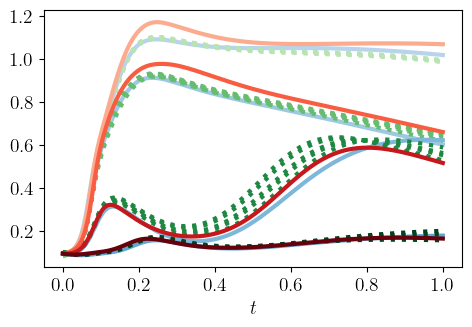

In [337]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

Nt = 1000

A_symb = np.linspace(0, 1, 4)
colors_p = plt.cm.Blues(np.linspace(0.3, 1, len(A_int)))

colors_s = plt.cm.YlGn(np.linspace(0.3, 1, len(A)))


Nt=1000

for idx, a_ in enumerate(A):


    T_int=np.zeros(Nt)
    P_int=np.zeros(Nt)
    S_int=np.zeros(Nt)


    dt=0.001

    T_int[0]=0
    P_int[0]=np.mean(P0) #Initial conditions
    # P_int[0]=np.array(p[0]) #Initial conditions

    S_int[0]=np.array(s[0]) #Initial conditions
    for i in range(1,Nt):

        PSA=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        # PHI_S=tf.exp(net(PSA, W_a, b_a))
        
        PHI_t=net(PSA, W_phi, b_phi)
        PHI=PHI_t[...,0:1]
        PHI_S=tf.exp(PHI_t[...,1:2])
        # REVISAAAAAR
        # PHI_S=tf.exp(predict(tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
        P_int[i]=P_int[i-1]+P_int[i-1]*PHI*dt
        S_int[i]=S_int[i-1]-P_int[i-1]*S_int[i-1]*PHI_S*dt
        T_int[i]=T_int[i-1]+dt


    plt.plot(T_int, P_int, linewidth=3,linestyle='-', label='$P_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_p[idx])
    # plt.plot(T_int, S_int,  linestyle='--', label=f'Numeric integration dSdT {a}')

    i=0
    plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx], label='$\hat{P}$'+f' (A = {np.round(A[idx], 2)})')

    for i in range(1,n[idx]):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx])


colors_p = plt.cm.Reds(np.linspace(0.3, 1, len(A)))
colors_s = plt.cm.YlGn(np.linspace(0.3, 1, len(A)))

for idx, a_ in enumerate(A_symb):
    T_symb = np.zeros(Nt)
    P_symb = np.zeros(Nt)
    S_symb = np.zeros(Nt)

    dt = 0.001

    T_symb[0] = 0
    P_symb[0] = np.mean(P0)  # Initial conditions
    S_symb[0] = np.array(s[0])  # Initial conditions

    for i in range(1, Nt):
        PSA = tf.concat([
            tf.convert_to_tensor(P_symb[i - 1].reshape([-1, 1]), dtype=tf.float32),
            tf.convert_to_tensor(S_symb[i - 1].reshape([-1, 1]), dtype=tf.float32),
            tf.convert_to_tensor(a_.reshape([-1, 1]), dtype=tf.float32)
        ], 1)

        PHI_S = model_phi.predict(PSA, [0, choose_s_2])[..., 1:2] * (max_cols_phi_s - min_cols_phi_s) + min_cols_phi_s
        PHI = net(PSA, W_phi, b_phi)[...,0:1]

        P_symb[i] = P_symb[i - 1] + P_symb[i - 1] * PHI * dt
        S_symb[i] = S_symb[i - 1] - S_symb[i - 1] * PHI_S * P_symb[i-1] * dt
        T_symb[i] = T_symb[i - 1] + dt

    plt.plot(T_symb, P_symb, linewidth=3, linestyle='-', label=f'$A = {np.round(a_, 2)}$', color=colors_p[idx])
    # plt.plot(T_symb, S_symb, linewidth=3, linestyle='--', color=colors_s[idx])


# plt.tight_layout()

# # Crear el colormap para la barra de colores
# norm = plt.Normalize(vmin=np.min(A_symb), vmax=np.max(A_symb))
# sm = cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
# sm.set_array([])  # Requerido para la barra de colores
# sm2 = cm.ScalarMappable(cmap=plt.cm.YlGn, norm=norm)
# sm2.set_array([])  # Requerido para la barra de colores
# # Añadir barra de colores
# cbar = plt.colorbar(sm, aspect=30, pad=0.02)
# cbar.set_label('$A$', fontsize=14)
# cbar.ax.tick_params(labelsize=12)
# cbar = plt.colorbar(sm2, aspect=30, pad=0.02)
# cbar.ax.tick_params(labelsize=12)
# Configuración del gráfico
# plt.legend(fontsize=14, ncols=2, frameon=False, bbox_to_anchor=(1, 1))
plt.xlabel('$t$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Guardar y mostrar
plt.savefig('../Img/512_2/Result_symb.png')
plt.savefig('../Img/512_2/Result_symb.pdf')
plt.savefig('../Img/512_2/Result_symb.svg')
# plt.show()
# 

In [ ]:
sgfdhgjhj

NameError: name 'sgfdhgjhj' is not defined

In [ ]:
m, l

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[42.86948]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[6.1390066]], dtype=float32)>)

: 

Soluciones de f(S) = 0: [7.00220078e-04 3.67713783e-02 2.89489556e-01 2.89489556e-01
 2.89489556e-01 2.89489556e-01 2.89489556e-01 2.89489556e-01
 2.89489556e-01 1.02094028e+00 1.02094028e+00 1.02094028e+00
 1.31517768e+00]


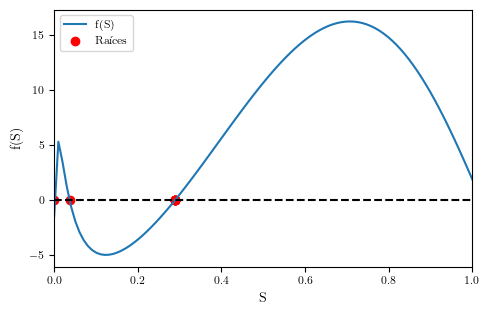

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import sympy as sp

P, S = sp.symbols('P S')

# Definir la función que representa el sistema de ecuaciones
def system(vars):
    P, S = vars
    f_S = expr.subs({'x1': S})-6.1390066  # Cambia esta expresión por la de tu función f(S)
    dP = f_S * P 
    dS = -42.86948 * S * P
    return [dP, dS]


# Definir variables simbólicas
# P, S = sp.symbols('P S')
# Define tu función f(S) y asegúrate de que solo depende de S
f_S = expr.subs({'x1': S})-6.1390066   # Define aquí la función f(S) correctamente

# Convertir f(S) en una función numérica
f_S_func = sp.lambdify(S, f_S, 'numpy')

# Rango para el diagrama de fases
S_values = np.linspace(0, 1, 50)
P_values = np.linspace(0, 1, 50)

# Crear la cuadrícula
P_grid, S_grid = np.meshgrid(P_values, S_values)
dP_vals = f_S_func(S_grid) * P_grid
dS_vals = -42.86948 * S_grid * P_grid

# Encontrar los puntos fijos usando fsolve
fixed_points = []
for P_init in np.linspace(0, 1, 50):  # Asegúrate de elegir un buen rango de inicialización
    for S_init in np.linspace(0, 1, 50):
        point = fsolve(system, [P_init, S_init])
        # Evitar duplicados al agregar puntos
        if not any(np.allclose(point, fp) for fp in fixed_points):
            fixed_points.append(point)



import scipy.optimize as opt


# Usar fsolve para encontrar las raíces de f(S) en un rango inicial
S_initial_guesses = np.linspace(0, 1, 20)  # Puedes ajustar el rango de las conjeturas iniciales
S_roots = [opt.fsolve(f_S_func, S0) for S0 in S_initial_guesses]

# Imprimir las soluciones
S_roots = np.unique(np.array(S_roots).flatten())  # Aplanar el resultado para eliminar listas anidadas
print("Soluciones de f(S) = 0:", S_roots)

# Graficar las soluciones
S_values = np.linspace(0, 1, 100)
f_values = f_S_func(S_values)

plt.plot(S_values, f_values, label="f(S)")
plt.axhline(0, color='black', linestyle='--')
plt.scatter(S_roots, f_S_func(S_roots), color='red', label='Raíces')
plt.xlabel('S')
plt.ylabel('f(S)')
plt.legend()
plt.xlim(0,1)
plt.show()



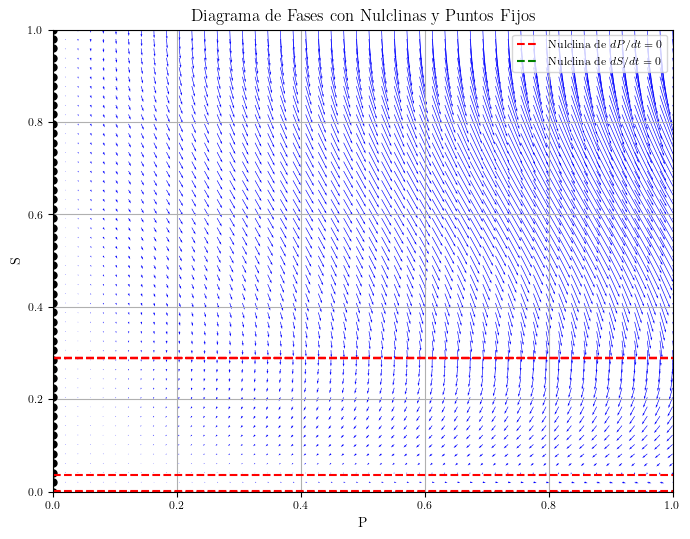

: 

In [ ]:
# Graficar el diagrama de fases con nulclinas y puntos fijos
plt.figure(figsize=(8, 6))
# plt.quiver(P_grid, S_grid, dP_vals, dS_vals, color='blue', alpha=0.5,scale=1, width=0.005)
plt.quiver(P_grid, S_grid, dP_vals, dS_vals, color='blue',scale=500, width=0.001)


# Graficar las nulclinas (solo como ejemplo)
plt.axhline(0, color='r', linestyle='--', label='Nulclina de $dP/dt = 0$')
plt.axvline(0, color='g', linestyle='--', label='Nulclina de $dS/dt = 0$')

# Graficar los puntos fijos
for point in fixed_points:
    P_val, S_val = point
    plt.plot(P_val, S_val, 'ko', markersize=5)

for nulclina_P in S_roots:
    plt.axhline(nulclina_P, color='r', linestyle='--')



plt.xlabel('P')
plt.ylabel('S')
plt.title('Diagrama de Fases con Nulclinas y Puntos Fijos')
plt.ylim(0,1)
plt.xlim(0,1)

plt.legend()
plt.grid()
plt.show()

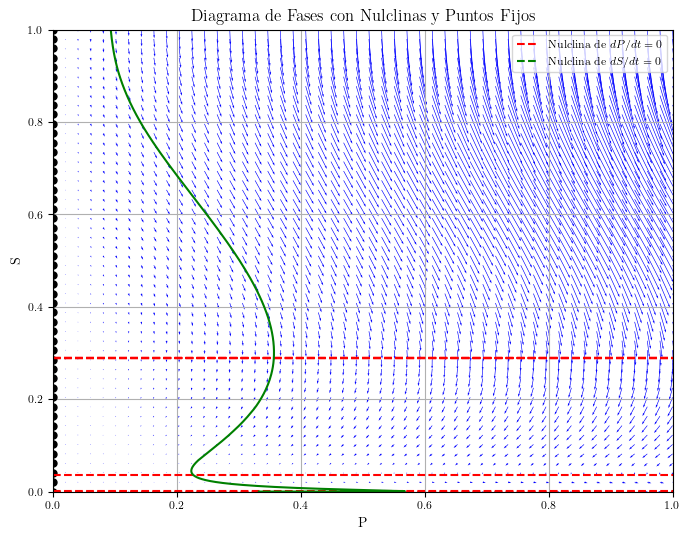

: 

In [ ]:
# Graficar el diagrama de fases con nulclinas y puntos fijos
plt.figure(figsize=(8, 6))
# plt.quiver(P_grid, S_grid, dP_vals, dS_vals, color='blue', alpha=0.5,scale=1, width=0.005)
plt.quiver(P_grid, S_grid, dP_vals, dS_vals, color='blue',scale=500, width=0.001)


# Graficar las nulclinas (solo como ejemplo)
plt.axhline(0, color='r', linestyle='--', label='Nulclina de $dP/dt = 0$')
plt.axvline(0, color='g', linestyle='--', label='Nulclina de $dS/dt = 0$')

# Graficar los puntos fijos
for point in fixed_points:
    P_val, S_val = point
    plt.plot(P_val, S_val, 'ko', markersize=5)

for nulclina_P in S_roots:
    plt.axhline(nulclina_P, color='r', linestyle='--')


plt.plot(P_int, S_int, color='green')
plt.xlabel('P')
plt.ylabel('S')
plt.title('Diagrama de Fases con Nulclinas y Puntos Fijos')
plt.legend()
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.show()